# Data Analysis and Preprocess

**Note**: Take into account that all this analysis and preprocess depends on the language that you are working with. In this case, the original dataset is in **English**.

In [1]:
# Just a bunch of libraries that I've used in the notebook
import psycopg2 as pg
from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
import statistics
import math
import re

import string
import spacy
from spacy.lang.en import English

import matplotlib.pyplot as plt
from collections import Counter

## Read the dataset

Despite you will find your dataset in a CSV, in this respository the data is stored in a database. Here I have defined a few functions to manage the connection with the database and parse the results.

In [2]:
def create_connection(db_params):
    conn = pg.connect(user = db_params['user'],
                            password = db_params['pass'],
                            host = db_params['host'],
                            port = db_params['port'],
                            database = db_params['database'])
    return conn

In [3]:
def close_connection(conn):
    conn.close()

In [4]:
# Parse the column of data and the category, and transform them into a Pandas DataFrame to
# work in an easier way with them
def parse_query_result(query_result):
    result = {'text': [], 'category': []}
    for row in query_result:
        result['text'].append(row['text'])
        result['category'].append(row['category'])

    return pd.DataFrame(result, columns = ['text', 'category'])

In [5]:
# Params of database
db_params = {
    'host': 'localhost',
    'user': 'postgres',
    'pass': '',
    'port': '54320',
    'database': 'tc'
}

In [6]:
# Create connection and cursor
conn = create_connection(db_params)
cursor = conn.cursor(cursor_factory=RealDictCursor)

sql = 'SELECT '\
      '    t.text, '\
      '    t.category '\
      'FROM texts t'
cursor.execute(sql)
query_result = cursor.fetchall()

close_connection(conn)

In [7]:
df = parse_query_result(query_result)
df.head() # Sample

,text,category
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment
1,"U2's desire to be number one\n\nU2, who have w...",entertainment
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment
3,Snicket tops US box office chart\n\nThe film a...,entertainment
4,Ocean's Twelve raids box office\n\nOcean's Twe...,entertainment


## Overview of dataset

As you can see in the following plot, the samples **are not balanced**. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

With this simple SQL query, we can see the number of texts for each category:
```sql
SELECT
    t.category,
    COUNT(*) total
FROM texts t
GROUP BY t.category
ORDER BY total DESC
```

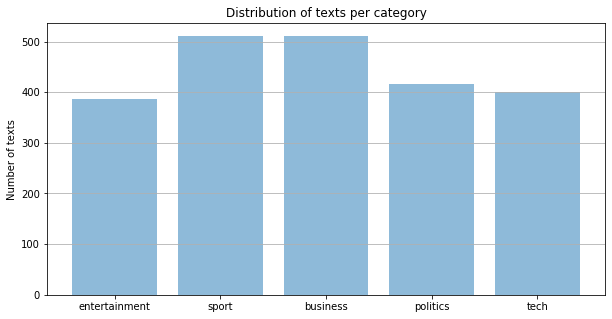

Counter({'sport': 511, 'business': 510, 'politics': 417, 'tech': 401, 'entertainment': 386})


In [54]:
categories = df[['category']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In order to compare the results later, I have defined a function to calculate the statistics of the dataset, and then I have used it after each preprocess step.

In [9]:
def calculate_stats(df, split_char=' '):
    categories = df['category'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['category']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

In [10]:
def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['category'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In these histograms and stats, we can see that almost all texts contain $1000$ or less words. Also, we can see that the average length is very different depending on the category.

In [11]:
df_stats = {} # Here we will store the statistics after each preprocess

df_stats['initial'] = calculate_stats(df)
df_stats['initial']['per_category']

,lengths,mean,stdev
entertainment,"[379, 839, 359, 177, 252, 334, 253, 312, 212, ...",331.621762,261.795254
sport,"[127, 150, 161, 142, 148, 138, 1384, 496, 400,...",330.262231,187.963267
business,"[186, 143, 188, 325, 449, 547, 174, 151, 144, ...",329.880392,135.919077
politics,"[224, 576, 586, 249, 428, 495, 463, 456, 202, ...",454.973621,300.120275
tech,"[447, 217, 582, 278, 501, 375, 467, 368, 356, ...",503.695761,239.849176


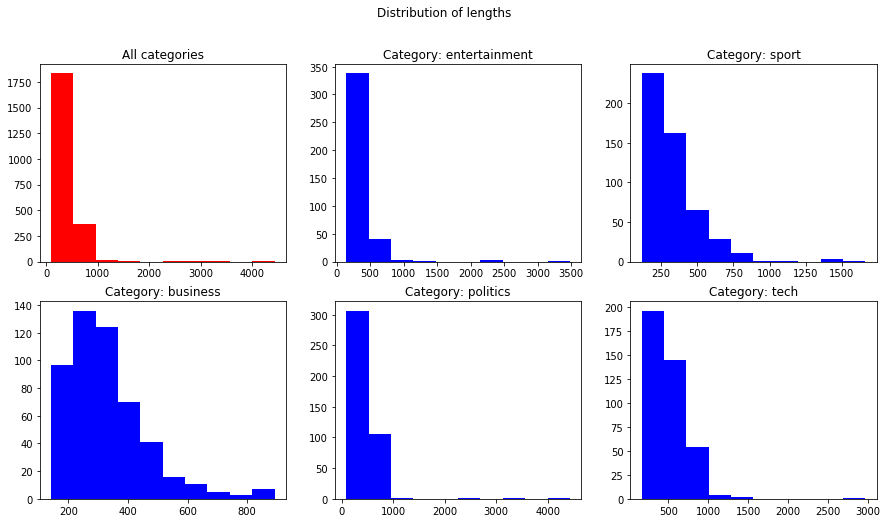

In [12]:
display_lengths_histograms(df_stats['initial'])

## Preprocess: clean characters

Before I start to apply other techniques to clean the texts, I have removed every character which cannot be used to write words in English (this set of characters is different in other languages). Using the following function, I have removed all puntuation symbols from all texts as well as I have normalized the white spaces.

In [14]:
def apply_char_cleaner(df):
    for index, row in df.iterrows():
        text = row['text']
        
        for symbol in list(string.punctuation) :
            # Replace the string
            text = text.replace(symbol, ' ')

        # Normalize white spaces
        text = re.sub(r"\s+", ' ', text)
        
        row['text'] = text
    
    return df

In [15]:
df = apply_char_cleaner(df)
df.head() # Sample

,text,category
0,Musicians to tackle US red tape Musicians grou...,entertainment
1,U2 s desire to be number one U2 who have won t...,entertainment
2,Rocker Doherty in on stage fight Rock singer P...,entertainment
3,Snicket tops US box office chart The film adap...,entertainment
4,Ocean s Twelve raids box office Ocean s Twelve...,entertainment


In [16]:
df_stats['char_cleaner'] = calculate_stats(df)
df_stats['char_cleaner']['per_category']

,lengths,mean,stdev
entertainment,"[387, 852, 370, 185, 270, 346, 254, 340, 221, ...",340.958549,267.569471
sport,"[133, 163, 166, 144, 153, 143, 1433, 527, 407,...",342.142857,193.835379
business,"[188, 146, 192, 330, 458, 586, 183, 157, 144, ...",339.323529,138.047525
politics,"[229, 582, 593, 257, 434, 508, 475, 460, 207, ...",462.544365,305.206438
tech,"[456, 224, 593, 279, 515, 383, 472, 377, 361, ...",514.276808,243.082642


The average length is greater now but, why? Since I have _normalized_ the characters in the texts, there are many more white spaces now, hence apparently there are more words. For example, if I had in the original text "*U2's desire*", now I have "*U2 s desire*" (i.e. one more word has appeared due to I have tokenized using the white spaces).

## Preprocess: Lematization

In this notebook, we are going to do **lematization** over all the texts. To do so, we will use the library **Spacy** since it already has detailed dictionaries which the algorithm can look through to link the form back to its lemma.

We can illustrate the method with an example:

| Word | Lemma |
|---|---|
| studying | study |
| studies | study |

This process may look similar to *stemming* (which we are not going to use), but it leads to a different result.

In [17]:
def apply_lematization(df, join_char=' '):
    nlp = English()

    for index, row in df.iterrows():
        text = row['text']
        tokens = nlp(text)
        text = [ w.lemma_.strip().lower() if w.lemma_ != "-PRON-" else w.lower_ for w in tokens ]
        row['text'] = join_char.join(text)
    
    return df

In [18]:
df = apply_lematization(df)
df.head() # Sample

,text,category
0,musicians to tackle us red tape musicians grou...,entertainment
1,u2 s desire to be number one u2 who have won t...,entertainment
2,rocker doherty in on stage fight rock singer p...,entertainment
3,snicket tops us box office chart the film adap...,entertainment
4,ocean s twelve raids box office ocean s twelve...,entertainment


In [19]:
df_stats['lematization'] = calculate_stats(df)
df_stats['lematization']['per_category']

,lengths,mean,stdev
entertainment,"[387, 851, 370, 190, 284, 345, 254, 372, 220, ...",341.756477,267.512869
sport,"[132, 162, 165, 144, 152, 142, 1433, 526, 406,...",342.199609,194.892085
business,"[188, 150, 191, 329, 457, 585, 182, 156, 146, ...",340.292157,138.200201
politics,"[228, 586, 601, 256, 433, 507, 475, 459, 206, ...",462.916067,306.206685
tech,"[457, 223, 594, 278, 515, 382, 475, 376, 360, ...",514.389027,243.494452


## Preprocess: Stop words

Stop words are a set of commonly used words in any language. For example, in English, "the", "is" and "or", would easily qualify as stop words. These words are not semantically useful in the sentences, thus it is a good idea to remove them and focus on important words instead.

In [20]:
def apply_stop_words(df, join_char=' ', split_char=' '):
    stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation)
    nlp = English()

    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        text = [w for w in tokens if w not in stop_words]
        row['text'] = join_char.join(text)
    
    return df

In [21]:
df = apply_stop_words(df)
df.head() # Sample

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 s desire number u2 won prestigious grammy a...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean s raids box office ocean s crime caper s...,entertainment


In [22]:
df_stats['stop_words'] = calculate_stats(df)
df_stats['stop_words']['per_category']

,lengths,mean,stdev
entertainment,"[189, 422, 195, 121, 190, 213, 143, 254, 132, ...",190.419689,130.869798
sport,"[97, 93, 102, 80, 82, 78, 775, 290, 255, 78, 7...",179.483366,103.789546
business,"[104, 96, 121, 187, 260, 366, 114, 95, 90, 149...",195.225490,73.724612
politics,"[129, 323, 324, 133, 234, 267, 263, 207, 126, ...",242.575540,142.432507
tech,"[221, 129, 316, 149, 259, 189, 250, 192, 185, ...",270.174564,114.610098


Now we can see that, after I have removed the *stop words*, the average lengths have decreased significantly.

## Preprocess: TF-IDF

The TF-IDF value is calculated by multiplying the term frequency by the inverse document frequency (see https://en.wikipedia.org/wiki/Tf-idf). 

In the following code, I have removed the words based on the TF-IDF value. That is, I have removed from the dataset those words whose TF-IDF value is less than a certain threshold.

In [24]:
def calculate_tf(df, split_char=' '):
    tf = []
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        
        words_freqs = {}
        for w in tokens:
            words_freqs[w] = 1 if w not in words_freqs else (words_freqs[w] + 1)
        
        max_freq = max(list(words_freqs.values()))
        words_freqs = {w:(abs_freq / max_freq) for w, abs_freq in words_freqs.items()}
        
        tf.append(words_freqs)
    
    return tf

In [25]:
def calculate_idf(df, split_char=' '):
    idf = {}
    n_docs = len(df.index)
    
    count_usage = {}
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        
        vocabulary_in_doc = list(set(tokens))
        for w in vocabulary_in_doc:
            if w not in count_usage:
                count_usage[w] = 1
            else:
                count_usage[w] += 1
    
    for w, count in count_usage.items():            
        idf[w] = math.log(n_docs / count)
    
    return idf

In [28]:
def calculate_tf_idf(df, split_char=' '):
    tf = calculate_tf(df, split_char)
    idf = calculate_idf(df, split_char)
    
    tf_idf = []
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        vocabulary_in_doc = list(set(tokens))
        
        row_tf_idf = {}
        for w in vocabulary_in_doc:
            row_tf_idf[w] = tf[index][w] * idf[w]
        
        tf_idf.append(row_tf_idf)
    
    return tf_idf

To find the threshold value for each document $d$, first I did some computations.

I have normalized the TF-IDF values as a distribution function. This means that the sum of all TF-IDF values is $1$:

$$\sum_{w\ \in\ d} \text{tf-idf}(w, d) = 1$$

Then, after I sorted the TF-IDF values in descendant order, I have calculated the value $k$ such as the sum

$$\sum_{i = 1}^{k} \text{tf-idf}(w_i, d)$$

is less than a certain p-value (in this code, I used $0.975$).

Finally, the value $\text{tf-idf}(w_k, d)$ is the threshold that I have used in the document $d$.

In [29]:
def apply_tf_idf(df, split_char=' ', join_char=' '):
    all_tf_idf = calculate_tf_idf(df, split_char)
    
    for doc_i, doc_tf_idf in enumerate(all_tf_idf):
        doc_tf_idf = {k: v for k, v in sorted(doc_tf_idf.items(), key=lambda item: item[1], reverse=True)}
        doc_tf_idf_values = np.array(list(doc_tf_idf.values()))

        probs = doc_tf_idf_values / sum(doc_tf_idf_values)
        
        p_value = 0
        for i, p in enumerate(probs):
            if p_value < 0.975:
                p_value += p
            else:
                break
        
        threshold = doc_tf_idf_values[i]
        
        row = df.loc[doc_i, :]
        tokens = row['text'].split(split_char)
        i = len(tokens)
        
        original_tokens = tokens.copy()
        while i >= 0:
            i -= 1
            
            w = tokens[i]
            if doc_tf_idf[w] < threshold:
                del tokens[i]
            
        
        doc_tf_idf = {k: v for k, v in sorted(doc_tf_idf.items(), key=lambda item: item[1])}        
        row['text'] = join_char.join(tokens)
    
    return df

In [31]:
df = apply_tf_idf(df)
df.head() # Sample

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean raids box office ocean crime caper seque...,entertainment


In [32]:
df_stats['tf_idf'] = calculate_stats(df)
df_stats['tf_idf']['per_category']

,lengths,mean,stdev
entertainment,"[165, 375, 174, 108, 167, 189, 130, 230, 115, ...",168.585492,118.648402
sport,"[86, 86, 92, 72, 71, 68, 703, 257, 226, 71, 71...",159.681018,92.709783
business,"[90, 82, 105, 169, 229, 321, 100, 85, 82, 127,...",172.876471,65.119283
politics,"[115, 297, 289, 116, 208, 235, 231, 183, 113, ...",215.347722,128.812873
tech,"[194, 117, 274, 135, 223, 170, 222, 165, 168, ...",241.835411,103.570666


## Summary of parsed dataset

<Figure size 1080x576 with 0 Axes>

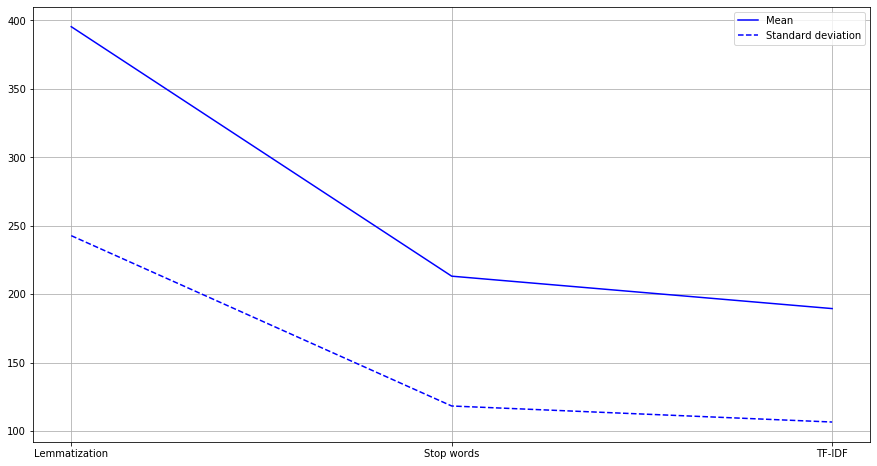

In [43]:
plt.figure(figsize=(15, 8))

# Subplot of all lengths
names = ['lematization', 'stop_words', 'tf_idf']
mean = []
stdev = []

for name, ds in df_stats.items():
    if name not in names:
        continue
    
    mean.append(ds['global']['mean'])
    stdev.append(ds['global']['stdev'])

x = ['Lemmatization', 'Stop words', 'TF-IDF']

plt.figure(figsize=(15, 8))
plt.plot(x, mean, color='b', label='Mean', linestyle='-')
plt.plot(x, stdev, color='b', label='Standard deviation', linestyle='--')
plt.grid()
plt.legend()
plt.show()

## Store parsed dataset

Finally, I have stored the dataset as a CSV file, so I could use it to train different models :)

In [49]:
df.to_csv('../data/parsed/tfidf_dataset.csv', index_label=False)